In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matrixensembles import BosonChainSampler, MatrixStats, BosonOHSampler
from studies import ManyBodyLevels
import time
from utils import bosonmatplot, errorhist, paramstring
from operators import BosonSystemSpec

### BosonChainSampler example

Simulation shows delocalized behaviour in the presence of perturbation

In [79]:
n, e = 3, 3
sampler = BosonChainSampler(n, 0.1, 0, K=1, e=e)
systemspec = BosonSystemSpec(n, e)
stats = MatrixStats(sampler)
stats.collect(1)
time.sleep(.01)
bosonmatplot(systemspec, sample:=sampler.sample(), np.linalg.eigvalsh(sample))

100%|██████████| 1/1 [00:00<00:00, 109.97it/s]

E:  30.3 32.2 32.2 32.3 32.4 32.5 32.5 36 36.5 36.5 

36 0 0 0 0 0 0 0 0 0  ;  3 0 0
0 32.2 0 0 0 0 0 0 0 0  ;  2 1 0
0 0 32.2 0 0 0 0 0 0 0  ;  2 0 1
0 0 0 32.3 0 0 0 0 0 0  ;  1 2 0
0 0 0 0 30.3 0 0 0 0 0  ;  1 1 1
0 0 0 0 0 32.4 0 0 0 0  ;  1 0 2
0 0 0 0 0 0 36.5 0 0 0  ;  0 3 0
0 0 0 0 0 0 0 32.5 0 0  ;  0 2 1
0 0 0 0 0 0 0 0 32.5 0  ;  0 1 2
0 0 0 0 0 0 0 0 0 36.5  ;  0 0 3


In [ ]:
d, n, w0 = 1, 10, 100
t, W, K = 1, 2, 1
TYPE = 'oscillators'
matrixstats = MatrixStats(BosonChainSampler(n, W, t, e=4, w0=w0, K=K))
matrixstats.collect(n_realizations=100, eigenvectors=False)
print(f"r = {np.mean(matrixstats.d2correlations())}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:10<00:00,  9.74it/s]

r = 0.4863145744848199


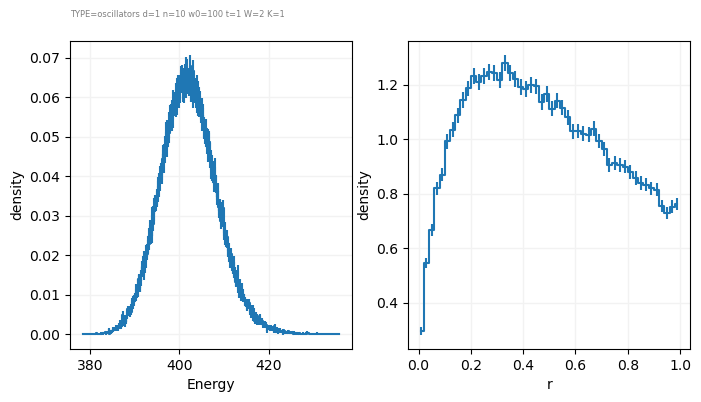

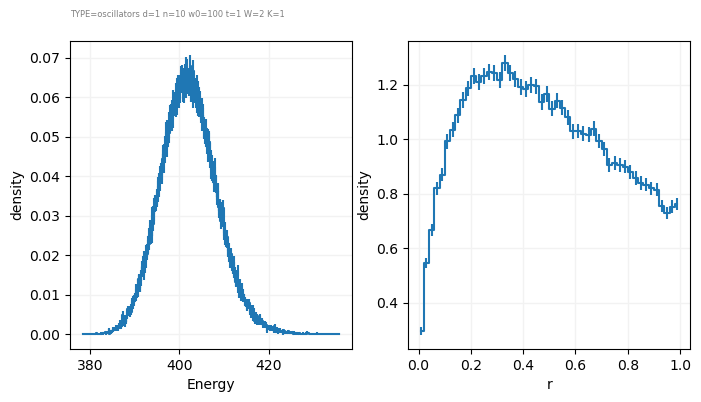

In [ ]:
manybody = matrixstats
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
params = dict(TYPE=TYPE, d=d, n=n, w0=w0, t=t, W=W, K=K)
errorhist(ax[0], manybody.eigenvalues().flatten(), bins=500)
ax[0].set_xlabel("Energy")
ax[0].text(0, 1.1, paramstring(params, 'plot'), fontsize=6, color='gray', transform=ax[0].transAxes, verticalalignment='top')
errorhist(ax[1], manybody.d2correlations().flatten(), bins=50)
ax[1].set_xlabel("r")
ax[0].lines[-1].set_label('K=0.1')
fig

## Many body test
When simulating a system of bosons with no interactions (K=0), the energy of a many body state is the sum of the energies of the single particle states that produce it. Here the simulation is verified by checking that this is true numerically.
The first simulation calculates the single-particle eigenenergies. The second one uses the previous values to calculate the many-particle energies. The last one directly calculates the many-body energies with a full manybody simulation.

In [86]:
n = 3
t = 1
W = 1
sampler = BosonChainSampler(n, W, t, K=0, e=1, rng=np.random.default_rng(42))
systemspec = BosonSystemSpec(n, 1)
time.sleep(.01)
print("Full matrix single")
bosonmatplot(systemspec, sampler.sample())
sampler = BosonChainSampler(n, W, t, K=0, e=1, rng=np.random.default_rng(42))
stats = MatrixStats(sampler)
stats.collect(1)
study = ManyBodyLevels(2)
manybody = study(stats)
print("\nManybody study")
print("E: ", " ".join([f"{v:.3g}" for v in manybody.eigenvalues().flatten()]))

sampler = BosonChainSampler(n, W, t, K=0, e=2, rng=np.random.default_rng(42))
systemspec = BosonSystemSpec(n, 2)
time.sleep(.01)
print("\nFull matrix manybody")
bosonmatplot(systemspec, sampler.sample())

Full matrix single
E:  8.33 9.52 12.2
S:  1.19 2.65 

10.3 1 1  ;  1 0 0
1 8.96 1  ;  0 1 0
1 1 10.8  ;  0 0 1


100%|██████████| 6/6 [00:00<00:00, 25140.68it/s]


Manybody study
E:  16.7 17.8 19 20.5 21.7 24.3

Full matrix manybody
E:  16.7 17.8 19 20.5 21.7 24.3
S:  1.19 1.19 1.46 1.19 2.65 

20.6 1.41 1.41 0 0 0  ;  2 0 0
1.41 19.3 1 1.41 1 0  ;  1 1 0
1.41 1 21.1 0 1 1.41  ;  1 0 1
0 1.41 0 17.9 1.41 0  ;  0 2 0
0 1 1 1.41 19.7 1.41  ;  0 1 1
0 0 1.41 0 1.41 21.5  ;  0 0 2


## Many body: full vs diagonal
BosonOHSampler shows a transition from 0.53 to 0.45 when used with e=n//2. Does this also happen when the energies are computed from the single-particle ones?

In [94]:
d, n, w0 = 1, 14, 100
W, t, K = 3, 1, 1
TYPE='oscillators'
study = ManyBodyLevels(n_excitations=None, K=K)

def correlation_transition(corr_W, n):
	corr_r, corr_err = np.zeros_like(corr_W, dtype=np.float64), np.zeros_like(corr_W, dtype=np.float64)
	for i, W in enumerate(corr_W):
		# singlestats = MatrixStats(LatticeSampler(d, n, W, t, w0))
		matrixstats = MatrixStats(BosonChainSampler(n, W, t, K=K))
		# matrixstats = MatrixStats(BosonOHSampler(n, W))
		matrixstats.collect(n_realizations=20)
		# singlestats.collect(n_realizations=10)
		# matrixstats = study(singlestats)
		r = matrixstats.d2correlations()
		r_avg = np.mean(r, axis=1) # average over disorder and states
		corr_r[i] = np.mean(r_avg)
		corr_err[i] = np.std(r_avg) / np.sqrt(r_avg.size)
	return corr_W, corr_r, corr_err

correlation_results = {}
for i, L in enumerate([10]):
	corr_W = np.arange(2, 11)
	corr_W, corr_r, corr_err = correlation_transition(corr_W, L)
	correlation_results[L] = (corr_W, corr_r, corr_err)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


Text(0, 1.1, 'TYPE=oscillators d=1 n=14 w0=100 t=1 W=3 K=1')

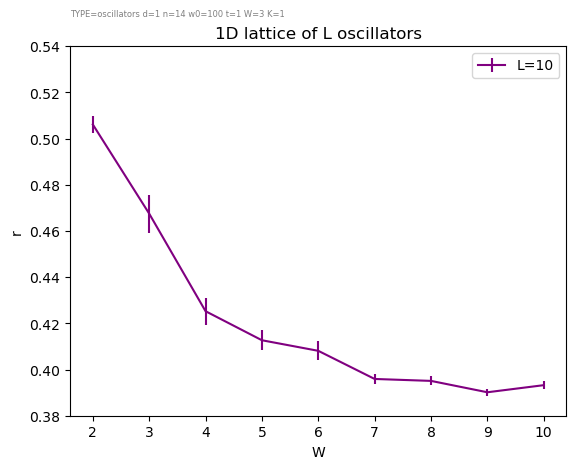

In [95]:
c = iter(["purple", "red", "yellow", "green", "blue"])
# restore default plot size

for L, (corr_W, corr_r, corr_err) in correlation_results.items():
	plt.errorbar(corr_W, corr_r, yerr=corr_err, label=f'L={L}', fmt='-', color=next(c))
plt.xlabel("W")
plt.ylabel("r")
plt.title("1D lattice of L oscillators")
plt.ylim(0.38, 0.54)
plt.legend()
params = dict(TYPE=TYPE, d=d, n=n, w0=w0, t=t, W=W, K=K)
plt.text(0, 1.1, paramstring(params, 'plot'), fontsize=6, color='gray', transform=plt.gca().transAxes, verticalalignment='top')

In [47]:
d, n, w0 = 1, 14, 100
W, t, K = 3, 1, 0
TYPE='oscillators'
study = ManyBodyLevels(n_excitations=None, K=K)

def correlation_transition(corr_W, n):
	corr_r, corr_err = np.zeros_like(corr_W, dtype=np.float64), np.zeros_like(corr_W, dtype=np.float64)
	for i, W in enumerate(corr_W):
		singlestats = MatrixStats(BosonOHSampler(n, W, e=1))
		singlestats.collect(n_realizations=10)
		matrixstats = study(singlestats)
		r = matrixstats.d2correlations()
		r_avg = np.mean(r, axis=1) # average over disorder and states
		corr_r[i] = np.mean(r_avg)
		corr_err[i] = np.std(r_avg) / np.sqrt(r_avg.size)
	return corr_W, corr_r, corr_err

correlation_results = {}
for i, L in enumerate([10]):
	corr_W = np.arange(2, 11)
	corr_W, corr_r, corr_err = correlation_transition(corr_W, L)
	correlation_results[L] = (corr_W, corr_r, corr_err)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 2002/2002 [00:00<00:00, 54436.52it/s]


Text(0, 1.1, 'TYPE=oscillators d=1 n=14 w0=100 t=1 W=3 K=0')

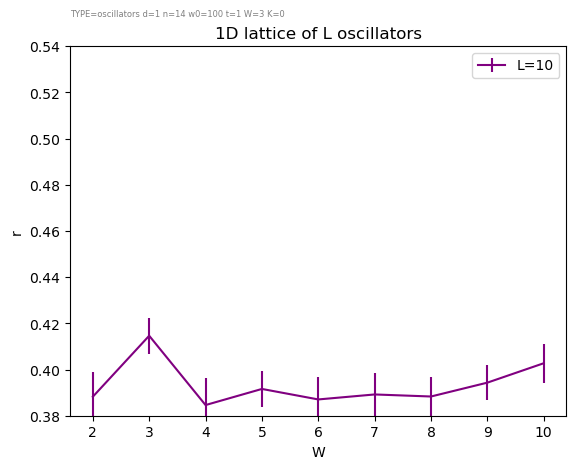

In [49]:
c = iter(["purple", "red", "yellow", "green", "blue"])
# restore default plot size

for L, (corr_W, corr_r, corr_err) in correlation_results.items():
	plt.errorbar(corr_W, corr_r, yerr=corr_err, label=f'L={L}', fmt='-', color=next(c))
plt.xlabel("W")
plt.ylabel("r")
plt.title("1D lattice of L oscillators")
plt.ylim(0.38, 0.54)
plt.legend()
params = dict(TYPE=TYPE, d=d, n=n, w0=w0, t=t, W=W, K=K)
plt.text(0, 1.1, paramstring(params, 'plot'), fontsize=6, color='gray', transform=plt.gca().transAxes, verticalalignment='top')